In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset

In [2]:
tr_df = pd.read_csv('train_data.csv', index_col=0)

In [3]:
dr_ind = tr_df[abs(tr_df['diff_dist'])>150].index

In [4]:
tr_df[abs(tr_df['diff_dist'])<150]

,Id,route_distance_km,delta_time,hours,sym_hours_periods,time,distance,speed_from_node,diff_nodes,diff_dist
12,247442490992434998,3404.0,556.0,17,4,495.367968,3509.135937,7.083898,1,-105.135937
15,8753872071393012841,1714.0,394.0,8,4,226.181119,1804.775189,7.979336,3,-90.775189
19,-4799447581923539182,1504.0,409.0,15,2,235.690269,1357.723879,5.760628,2,146.276121
25,-6722633671062720412,1813.0,418.0,14,1,275.128378,1739.471206,6.322398,1,73.528794
26,2722667687781990889,2902.0,586.0,5,7,334.060803,3005.013846,8.995410,2,-103.013846
...,...,...,...,...,...,...,...,...,...,...
4975,3218356466285963367,2163.0,620.0,6,6,222.202665,2055.568664,9.250873,1,107.431336
4977,-4251387614414686994,5428.0,784.0,9,3,540.670687,5523.085865,10.215249,3,-95.085865
4978,-3725034898234950230,1539.0,407.0,10,2,193.063127,1432.572235,7.420227,0,106.427765
4986,4752186707016702535,3272.0,327.0,3,9,295.350986,3160.018909,10.699199,3,111.981091


In [5]:
len(dr_ind)

4204

In [6]:
tr_df.drop(dr_ind, axis = 0, inplace = True)

In [7]:
sc1 = StandardScaler()

X1 = tr_df1.iloc[:, [1, 3,4,6,7,8,9]].to_numpy()
X_norm1 = sc1.fit_transform(X1)
y1 = tr_df1.iloc[:, 2].to_numpy()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_norm1, y1, test_size=0.1, random_state=0, shuffle=True)

X_train_t1 = torch.from_numpy(X_train1.astype(np.float32))
X_test_t1 = torch.from_numpy(X_test1.astype(np.float32))

y_train_t1 = torch.from_numpy(y_train1.astype(np.float32))
y_train_t1 = y_train_t1.view(y_train_t1.shape[0], 1)
y_test_t1 = torch.from_numpy(y_test1.astype(np.float32))
y_test_t1 = y_test_t1.view(y_test_t1.shape[0], 1)

NameError: name 'tr_df1' is not defined

In [7]:
sc = StandardScaler()

X = tr_df.iloc[:, [1, 3,4,6,7,8,9]].to_numpy()
X_norm = sc.fit_transform(X)
y = tr_df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.1, random_state=42, shuffle=True)

X_train_t = torch.from_numpy(X_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))

y_train_t = torch.from_numpy(y_train.astype(np.float32))
y_train_t = y_train_t.view(y_train_t.shape[0], 1)
y_test_t = torch.from_numpy(y_test.astype(np.float32))
y_test_t = y_test_t.view(y_test_t.shape[0], 1)

In [8]:
class ConsumptionDataset_train(Dataset):

    def __init__(self, X_train_t, y_train_t):
        # Initialize data, download, etc.
        # read with numpy or pandas
        self.x_data = X_train_t
        self.y_data = y_train_t
        self.n_samples = X_train_t.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    

In [9]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [10]:
n_input_features = X_train_t.shape[1]

In [11]:
data_train = ConsumptionDataset_train(X_train_t, y_train_t)

num_epochs = 200
batch_size = 30

train_loader = DataLoader(dataset=data_train,
                          batch_size=batch_size)

In [13]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LinearRegression, self).__init__()
        torch.manual_seed(0)
        self.linear1 = nn.Linear(n_input_features, 4)
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(4,2)
        self.linear3 = nn.Linear(2,1)
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.tanh(z1)
        z2 = self.linear2(a1)
        a2 = self.lrelu(z2)
        #a1 = self.lrelu(z1)
        y_pred = self.relu(self.linear3(a2))
        return y_pred

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LinearRegression, self).__init__()
        torch.manual_seed(0)
        self.linear1 = nn.Linear(n_input_features, 5)
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(5,4)
        self.linear3 = nn.Linear(4,2)
        self.linear4 = nn.Linear(2,1)
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.tanh(z1)
        z2 = self.linear2(a1)
        a2 = self.relu(z2)
        z3 = self.linear3(a2)
        a3 = self.relu(z3)
        y_pred = self.linear4(a3)
        return y_pred

In [13]:
model = LinearRegression(n_input_features)

learning_rate = 0.001
criterion = RMSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 3000, gamma = 0.1)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
train_rmse = []
test_rmse = []

best_valid_loss=float('inf')
best_model = copy.deepcopy(model)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):  
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        test_loss = criterion(model(X_test_t),y_test_t)
        if test_loss < best_valid_loss:
            best_model = copy.deepcopy(model)
            best_valid_loss = test_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (i+1) % 30 == 0:
           # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    train_rmse.append(loss.detach().numpy())
    test_rmse.append(criterion(model(X_test_t),y_test_t).detach().numpy())

In [15]:
print(np.min(test_rmse))

85.43065


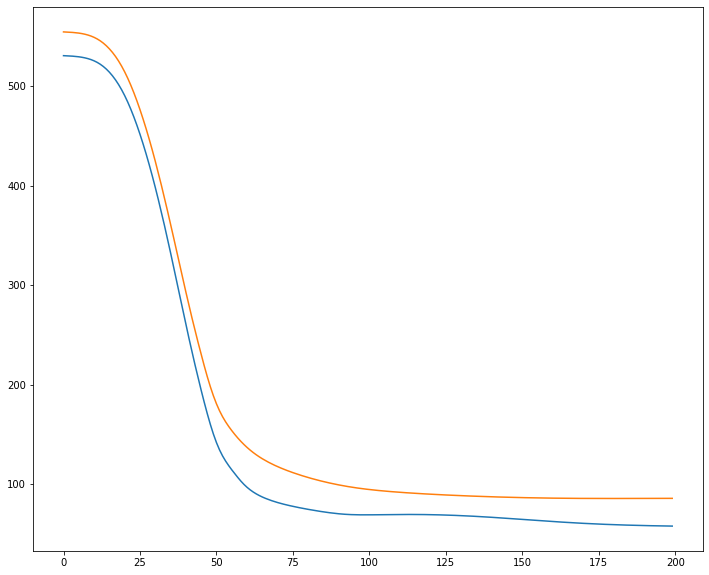

In [16]:
plt.figure(figsize=(12,10))
plt.plot(train_rmse)
plt.plot(test_rmse)

In [17]:
torch.save(best_model.state_dict(), 'best_model.pt')

# KFold

In [44]:
from sklearn.model_selection import KFold

In [39]:
class RaiderDataset_train(Dataset):

    def __init__(self, X_train_t, y_train_t):
        # Initialize data, download, etc.
        # read with numpy or pandas
        self.x_data = X_train_t
        self.y_data = y_train_t
        self.n_samples = X_train_t.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    

In [40]:
class RaiderDataset_test(Dataset):

    def __init__(self, X_test_t, y_test_t):
        # Initialize data, download, etc.
        # read with numpy or pandas
        self.x_data = X_train_t
        self.y_data = y_train_t
        self.n_samples = X_train_t.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    

In [32]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LinearRegression, self).__init__()
        torch.manual_seed(0)
        self.linear1 = nn.Linear(n_input_features, 5)
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(5,4)
        self.linear3 = nn.Linear(4,2)
        self.linear4 = nn.Linear(2,1)
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.tanh(z1)
        z2 = self.linear2(a1)
        a2 = self.relu(z2)
        z3 = self.linear3(a2)
        a3 = self.relu(z3)
        y_pred = self.linear4(a3)
        return y_pred

In [47]:
dataset_train_part = RaiderDataset_train(X_train_t, y_train_t)
dataset_test_part = RaiderDataset_test(X_test_t, y_test_t)

dataset = ConcatDataset([dataset_train_part, dataset_test_part])

In [48]:
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

In [51]:
num_epochs = 200

train_batch_size = 30
test_batch_size = y_test_t.shape[0]

all_loss = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(
                      dataset, 
                      batch_size=train_batch_size, sampler=train_subsampler)
    testloader = DataLoader(
                      dataset,
                      batch_size=test_batch_size, sampler=test_subsampler)
    
    # Init the neural network
    model = LinearRegression(n_input_features)
    
    
    # Initialize optimizer
    learning_rate = 0.001
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    best_valid_loss=float('inf')
    #best_model = copy.deepcopy(model)
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        for i, (X,y) in enumerate(trainloader, 0):
    
            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)
            
            test_loss = criterion(model(X_test_t),y_test_t)
            if test_loss < best_valid_loss:
                #best_model = copy.deepcopy(model)
                best_valid_loss = test_loss
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #if (i+1) % 30 == 0:
               # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    all_loss.append(best_valid_loss.detach().numpy())
        

        
        


FOLD 0
--------------------------------
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------
FOLD 4
--------------------------------


In [52]:
np.mean(all_loss)

85.25573